In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Data Preparation

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S')
df = pd.read_csv(r'C:\Users\Asia\Desktop\Università\Magistrale\Data Mining\Dm 2\Progetto\Dataset\datatraining.csv', header=0, index_col='date', date_parser = dateparse )
#df = df.drop(['Unnamed: 0'], axis = 1)
df.head()

In [73]:
light = df[["Temperature", "Occupancy"]]

In [74]:
ts_light=[]
ts_light_labels=[]
for i in range(0,len(light),20):
    try:
        if len(light.iloc[i:i+60,0].to_list())==60:
            ts_light.append(light.iloc[i:i+60,0].to_list())
            ts_light_labels.append(light.iloc[i:i+60,1].mean())
        else:
            pass
    except:
        pass
ts_light_labels=[1 if x>0.65 else 0 for x in ts_light_labels]

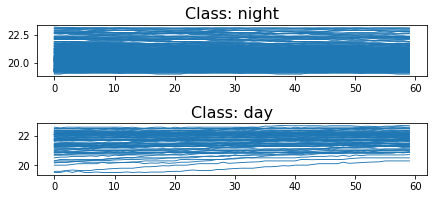

In [75]:
ts_labels=np.array(ts_light_labels)
ts=np.array(ts_light)

plt.figure()
for i, classe in enumerate(['night', 'day']):
    plt.subplot(3, 1, i + 1)
    for x in ts[ts_labels == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.9)
plt.show()

In [76]:
ts_no_zeros=[]
ts_no_zeros_labels=[]
ts_zeros=[]
ts_zeros_labels=[]
for i, x in enumerate(ts):
    if x.mean()==0:
        ts_zeros.append(x)
        ts_zeros_labels.append(ts_labels[i])
    else:
        ts_no_zeros.append(x)
        ts_no_zeros_labels.append(ts_labels[i])

In [77]:
X = ts

In [22]:
y = np.append(ts_no_zeros_labels, ts_zeros_labels)

In [23]:
X.shape

(405, 60)

In [24]:
y.shape

(405,)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [26]:
X_train.shape, y_train.shape


((283, 60), (283,))

In [27]:
X_test.shape, y_test.shape

((122, 60), (122,))

# Shapelet Discovery

https://tslearn.readthedocs.io/en/latest/gen_modules/shapelets/tslearn.shapelets.ShapeletModel.html#tslearn.shapelets.ShapeletModel

https://www.kaggle.com/group16/shapelets

In [28]:
from keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

Using TensorFlow backend.
C:\Users\Asia\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [29]:
len(set(y_train))

2

In [31]:
#ci serve la dimensionalità del dataset, il numero di time series e la lunghezza delle serie
n_ts, ts_sz = X_train.shape
n_classes = len(set(y_train)) #il numero di classi (3)

#metodo per torvare il numero corretto per la shaplet size, lenght in questo caso è 3
# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 283
ts_sz 60
n_classes 2
shapelet_sizes {6: 4}


In [32]:
#PRIMA DI QUESTO FARE LO SPLIT TRA TRAINING E TEST SET PER FARE LA PREDIZIONE DOPO!!!!!

# Define the shaplet model using parameters provided by the authors (except that we use
# fewer iterations here)
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",#può anche essere uno di keras
                        weight_regularizer=.01,
                        max_iter=200,
                        verbose=1)
#questo si basa su keras quindi l'output è simile a quello delle NN
#il modello è ottenuto dopo 200 epoch

In [33]:
shp_clf.fit(X_train, y_train)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/200
283/283 [==============================] - 0s 2ms/step - loss: 2.7506 - binary_accuracy: 0.1272 - binary_crossentropy: 2.7443
Epoch 2/200
283/283 [==============================] - 0s 53us/step - loss: 2.5223 - binary_accuracy: 0.1413 - binary_crossentropy: 2.5168
Epoch 3/200
283/283 [==============================] - 0s 39us/step - loss: 2.2800 - binary_accuracy: 0.1413 - binary_crossentropy: 2.2754
Epoch 4/200
283/283 [==============================] - 0s 45us/step - loss: 2.0428 - binary_accuracy: 0.1343 - binary_crossentropy: 2.0391
Epoch 5/200
283/283 [==============================] - 0s 45us/step - loss: 1.8442 - binary_accuracy: 0.1413 - binary_crossentropy: 1.8410
Epoch 6/200
283/283 [==============================] - 0s 42us/step - loss: 1.6531 - binary_accuracy: 0.1555 - binary_crossentropy

283/283 [==============================] - 0s 38us/step - loss: 0.3558 - binary_accuracy: 0.8057 - binary_crossentropy: 0.3531
Epoch 53/200
283/283 [==============================] - 0s 42us/step - loss: 0.3546 - binary_accuracy: 0.8057 - binary_crossentropy: 0.3519
Epoch 54/200
283/283 [==============================] - 0s 33us/step - loss: 0.3535 - binary_accuracy: 0.8057 - binary_crossentropy: 0.3507
Epoch 55/200
283/283 [==============================] - 0s 35us/step - loss: 0.3521 - binary_accuracy: 0.7915 - binary_crossentropy: 0.3493
Epoch 56/200
283/283 [==============================] - 0s 36us/step - loss: 0.3512 - binary_accuracy: 0.8057 - binary_crossentropy: 0.3484
Epoch 57/200
283/283 [==============================] - 0s 32us/step - loss: 0.3503 - binary_accuracy: 0.8057 - binary_crossentropy: 0.3475
Epoch 58/200
283/283 [==============================] - 0s 34us/step - loss: 0.3496 - binary_accuracy: 0.8057 - binary_crossentropy: 0.3467
Epoch 59/200
283/283 [===========

283/283 [==============================] - 0s 38us/step - loss: 0.3304 - binary_accuracy: 0.8304 - binary_crossentropy: 0.3263
Epoch 111/200
283/283 [==============================] - 0s 34us/step - loss: 0.3302 - binary_accuracy: 0.8304 - binary_crossentropy: 0.3261
Epoch 112/200
283/283 [==============================] - 0s 35us/step - loss: 0.3298 - binary_accuracy: 0.8410 - binary_crossentropy: 0.3256
Epoch 113/200
283/283 [==============================] - 0s 32us/step - loss: 0.3294 - binary_accuracy: 0.8375 - binary_crossentropy: 0.3252
Epoch 114/200
283/283 [==============================] - 0s 39us/step - loss: 0.3293 - binary_accuracy: 0.8375 - binary_crossentropy: 0.3251
Epoch 115/200
283/283 [==============================] - 0s 42us/step - loss: 0.3291 - binary_accuracy: 0.8410 - binary_crossentropy: 0.3249
Epoch 116/200
283/283 [==============================] - 0s 38us/step - loss: 0.3290 - binary_accuracy: 0.8410 - binary_crossentropy: 0.3247
Epoch 117/200
283/283 [====

283/283 [==============================] - 0s 35us/step - loss: 0.3241 - binary_accuracy: 0.8375 - binary_crossentropy: 0.3191
Epoch 169/200
283/283 [==============================] - 0s 40us/step - loss: 0.3239 - binary_accuracy: 0.8375 - binary_crossentropy: 0.3189
Epoch 170/200
283/283 [==============================] - 0s 36us/step - loss: 0.3239 - binary_accuracy: 0.8410 - binary_crossentropy: 0.3188
Epoch 171/200
283/283 [==============================] - 0s 36us/step - loss: 0.3238 - binary_accuracy: 0.8410 - binary_crossentropy: 0.3188
Epoch 172/200
283/283 [==============================] - 0s 37us/step - loss: 0.3238 - binary_accuracy: 0.8410 - binary_crossentropy: 0.3188
Epoch 173/200
283/283 [==============================] - 0s 40us/step - loss: 0.3238 - binary_accuracy: 0.8410 - binary_crossentropy: 0.3187
Epoch 174/200
283/283 [==============================] - 0s 42us/step - loss: 0.3237 - binary_accuracy: 0.8375 - binary_crossentropy: 0.3186
Epoch 175/200
283/283 [====

ShapeletModel(batch_size=256, max_iter=200, n_shapelets_per_size={6: 4},
              optimizer='sgd', random_state=None, shapelet_length=0.15,
              total_lengths=3, verbose=1, verbose_level=None,
              weight_regularizer=0.01)

In [34]:
from sklearn.metrics import accuracy_score

In [38]:
#STIAMO CLASSIFICANDO RISPETTO ALLA SHAPLET
predicted_labels = shp_clf.predict(X_test)
print("Correct classification rate:", accuracy_score(y_test, predicted_labels)) # y è la real label

122/122 [==============================] - 0s 8us/step
Correct classification rate: 0.8032786885245902


In [36]:
#STIAMO CLASSIFICANDO RISPETTO ALLA SHAPLET
predicted_labels = shp_clf.predict(X_train)
print("Correct classification rate:", accuracy_score(y_train, predicted_labels)) # y è la real label

283/283 [==============================] - 0s 24us/step
Correct classification rate: 0.8374558303886925


In [37]:
#questa funzione ci aiuta a trovare e visualizzare le shaplet
predicted_locations = shp_clf.locate(X_test)

122/122 [==============================] - 0s 570us/step


C:\Users\Asia\Anaconda3\lib\site-packages\tslearn\utils.py:63: UserWarning: 2-Dimensional data passed. Assuming these are 122 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


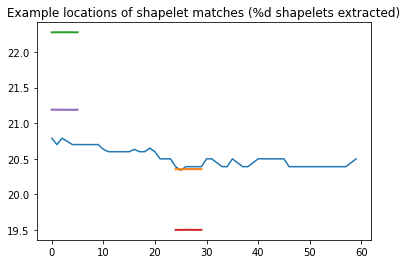

In [48]:
#in questo modo visualizzo le shaplet sulla prima istanza del dataset
ts_id = 49 #prima istanza
plt.figure()
n_shapelets = sum(shapelet_sizes.values())
plt.title("Example locations of shapelet matches "
          "(%d shapelets extracted)".format(n_shapelets))

plt.plot(X_test[ts_id].ravel())
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp] #qui allinea le serie con lo shaplet
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)
#utile per capire perchè una certa serie è classificata in base ad una certa label

## Shaplet Discovery 3

In [49]:
#TERZO MODO PER TROVARE LE SHAPLET
from pyts.transformation import ShapeletTransform
#permette di trasformare una serie in shaplet

https://pyts.readthedocs.io/en/stable/generated/pyts.transformation.ShapeletTransform.html#pyts.transformation.ShapeletTransform

In [50]:
#dobbiamo specificare il numero delle shaplet e il lenght
st = ShapeletTransform(n_shapelets=4, window_sizes=[5])
st.fit(X_train, y_train)

ShapeletTransform(criterion='mutual_info', n_jobs=None, n_shapelets=4,
                  random_state=None, remove_similar=True, sort=False, verbose=0,
                  window_sizes=[5], window_steps=None)

In [51]:
len(st.shapelets_)

4

In [52]:
st.shapelets_

array([[21.9725    , 21.96333333, 22.        , 22.        , 22.        ],
       [21.42666667, 21.39      , 21.4175    , 21.445     , 21.39      ],
       [21.42666667, 21.39      , 21.4175    , 21.445     , 21.39      ],
       [21.39      , 21.4175    , 21.42666667, 21.445     , 21.39      ]])

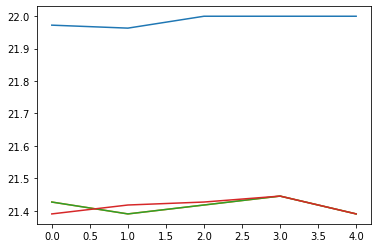

In [53]:
#qui visualizzo le shaplet, ma non ho il best allignment come con il primo
for s in st.shapelets_:
    plt.plot(s)

plt.show()

The indices for the corresponding shapelets in the training set. The first column consists of the indices of the samples. The second column consists of the starting indices (included) of the shapelets. The third column consists of the ending indices (excluded) of the shapelets.

In [54]:
#per trovare il best allignment devo fare questo
st.indices_

array([[14, 39, 44],
       [46,  8, 13],
       [80, 48, 53],
       [80,  5, 10]], dtype=int64)

In [55]:
X[2][55:63]

array([22.1, 22.1, 22.1, 22.1, 22.1])

In [56]:
st.scores_

array([0.25602791, 0.25634182, 0.26057192, 0.26390557])

## Shaplet Discovery 4

In [57]:
#ULTIMA LIBRERIA PER SHAPLET
from pyts.classification import LearningShapelets
#questa svolge la classificazione

https://pyts.readthedocs.io/en/stable/generated/pyts.classification.LearningShapelets.html#pyts.classification.LearningShapelets

In [58]:
shp_clf = LearningShapelets(random_state=42, tol=0.01)

In [59]:
shp_clf.fit(X_train, y_train)

LearningShapelets(C=1000, alpha=-100, class_weight=None, fit_intercept=True,
                  intercept_scaling=1.0, learning_rate=1.0, max_iter=1000,
                  min_shapelet_length=0.1, multi_class='multinomial',
                  n_jobs=None, n_shapelets_per_size=0.2, penalty='l2',
                  random_state=42, shapelet_scale=3, tol=0.01, verbose=0)

In [60]:
len(shp_clf.shapelets_[0])

36

In [61]:
from pyts.utils import windowed_view

In [62]:
# Select three shapelets
sel_shapelets = np.asarray([shp_clf.shapelets_[0, 0], 
                        shp_clf.shapelets_[0, 1], 
                        shp_clf.shapelets_[0, 2]])

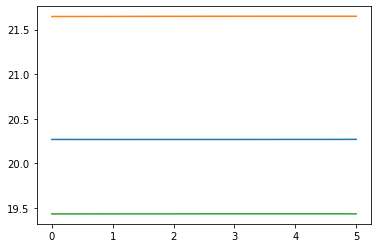

In [63]:
plt.plot(sel_shapelets[0])
plt.plot(sel_shapelets[1])
plt.plot(sel_shapelets[2])

plt.show()

In [64]:
# Derive the distances between the time series and a shapelets
shapelet_size = sel_shapelets.shape[1]
X_window = windowed_view(X, window_size=shapelet_size, window_step=1)
X_dist = np.mean((X_window[:, :, None] - sel_shapelets[None, :]) ** 2, axis=3).min(axis=1)

In [65]:
X_dist

array([[4.39744302e+00, 5.15959487e-01, 8.58913083e+00],
       [3.78991382e+00, 3.22235929e-01, 7.73147411e+00],
       [3.35496203e+00, 2.04540953e-01, 7.10474152e+00],
       ...,
       [4.69119460e-04, 1.46994363e+00, 7.31832582e-01],
       [4.69119460e-04, 8.27290485e-01, 7.31832582e-01],
       [4.69119460e-04, 3.83097441e-01, 7.31832582e-01]])

In [66]:
np.mean(X_dist[y == 0], axis=0)

array([0.65555061, 2.26459439, 1.39167406])

In [67]:
np.mean(X_dist[y == 1], axis=0)

array([1.96311775, 0.2015109 , 4.74363232])

In [68]:
np.mean(X_dist[y == 2], axis=0)

C:\Users\Asia\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Asia\Anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


array([nan, nan, nan])

# Matrix Profile

https://github.com/target/matrixprofile-ts

https://github.com/TDAmeritrade/stumpy

In [84]:
#anche per questa abbiamo due librerie da poter usare
#la prima dovrebbe essere più semplice ma la seconda è più efficente e stabile
from matrixprofile import *

In [85]:
ts = df['Temperature']

C:\Users\Asia\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


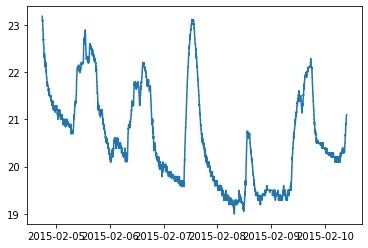

In [87]:
plt.plot(ts)
plt.show()

C:\Users\Asia\Anaconda3\lib\site-packages\matrixprofile\utils.py:177: RuntimeWarning: divide by zero encountered in true_divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
C:\Users\Asia\Anaconda3\lib\site-packages\matrixprofile\utils.py:177: RuntimeWarning: invalid value encountered in true_divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
C:\Users\Asia\Anaconda3\lib\site-packages\matrixprofile\distanceProfile.py:118: RuntimeWarning: invalid value encountered in sqrt
  distanceProfile = np.real(np.sqrt(mass(query,tsB).astype(complex)))
C:\Users\Asia\Anaconda3\lib\site-packages\matrixprofile\matrixProfile.py:249: RuntimeWarning: invalid value encountered in less
  idsToUpdate = distanceProfile < mp
C:\Users\Asia\Anaconda3\lib\site-packages\matrixprofile\utils.py:200: RuntimeWarning: divide by zero encountered in true_divide
  res = 2*m*(1-(dot-m*mean[index]*mean)/(m*std[index]*std))
C:\Users\Asia\Anaconda3\lib\site-packages\matrixprofile\utils.py:200: RuntimeWarning: invali

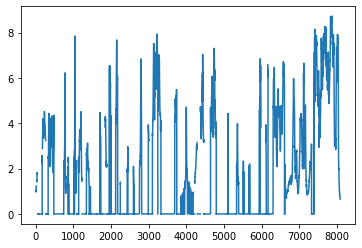

In [94]:
w = 60
mp, mpi = matrixProfile.stomp(ts.values, w) #stomp è una funzione per estrarre la matrix profile, specificando la finestra w
#mpi è il matrix profile index
plt.plot(mp)
plt.show()

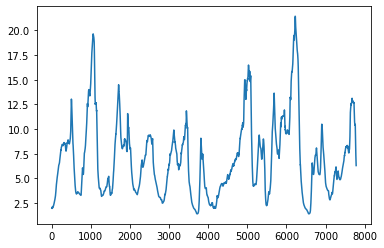

In [93]:
#invece se cambiamo la finestra cambia anche la matrix profile e quindi il grafico
w = 360
mp, mpi = matrixProfile.stomp(ts.values, w)

plt.plot(mp)
plt.show()
#i picchi sono probabilmente anomalie, e quelli vicini a 0 sono motivi

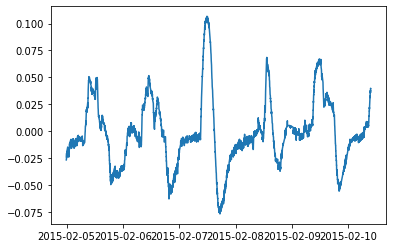

In [115]:
#qui plotto la serie su cui ho fatto le trasformazioni e applicato il rolling
window = 360
ts_log_mov_diff = pd.Series(np.log(ts) - np.log(ts).rolling(window, center=False).mean(), index=ts.index)

plt.plot(ts_log_mov_diff)
plt.show()

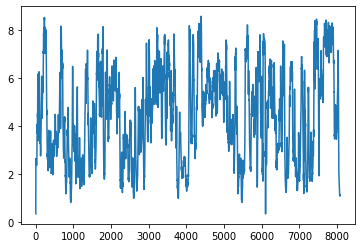

In [92]:
#per mostrare che anche se ho effettuato delle trasformazioni sulla serie otteniamo comunque una matrix profile simile a quella della serie non trasformata
w = 60
mp, mpi = matrixProfile.stomp(ts_log_mov_diff.values, w)

plt.plot(mp)
plt.show()
#la forma rimane più o meno la stessa, cambia un pò la variazione, ma di poco
#questo perchè la matrix profile è la stessa, non cambia anche applicando una trasformazione ai dati

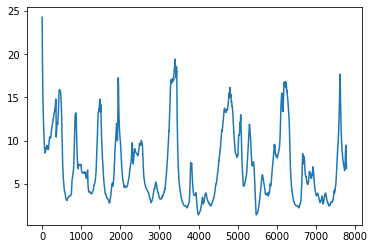

In [120]:
w = 360
mp, mpi = matrixProfile.stomp(ts_log_mov_diff.values, w)

plt.plot(mp)
plt.show()

# Motif Discovery

In [121]:
#mp_adj = np.append(mp[0],np.zeros(m-1)+np.nan)

mo, mod  = motifs.motifs(ts_log_mov_diff.values, (mp, mpi), max_motifs=5)#gli passi la serie e la matrix profile e l'indice, e specifichi quanti motivi voglio

C:\Users\Asia\Anaconda3\lib\site-packages\matrixprofile\distanceProfile.py:66: RuntimeWarning: invalid value encountered in sqrt
  distanceProfile = np.real(np.sqrt(mass(query,tsB).astype(complex)))


Parameters
- max_motifs: stop finding new motifs once we have max_motifs
- radius: For each motif found, find neighbors that are within radius*motif_mp of the first.
- n_neighbors: number of neighbors from the first to find. If it is None, find all.
- ex_zone: minimum distance between indices for after each subsequence is identified. Defaults to m/2 where m is the subsequence length. If ex_zone = 0, only the found index is exclude, if ex_zone = 1 then if idx is found as a motif idx-1, idx, idx+1 are excluded.

Returns
The function returns a tuple (top_motifs, distances) which are lists of the same length.

- top_motifs: This is a list of the indices found for each motif. The first index is the nth motif followed by all nearest neighbors found sorted by distances.
- distances: Minimum Matrix profile value for each motif set.

In [122]:
mo #sono gli indici dei motivi

[[3993, 5476], [3705, 6561], [4307, 7335], [2783, 7104]]

In [123]:
mod # la distanza tra i motivi, che è molto bassa, quasi 0

[1.4134640662464548, 2.2261983334410544, 2.465420628422095, 2.828567225944148]

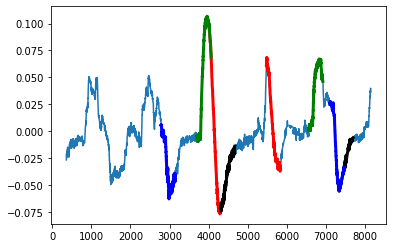

In [124]:
#possiamo plottare i motivi per trovarli sulla serie originale
# e separatamente
plt.plot(ts_log_mov_diff.values)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = ts_log_mov_diff.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()

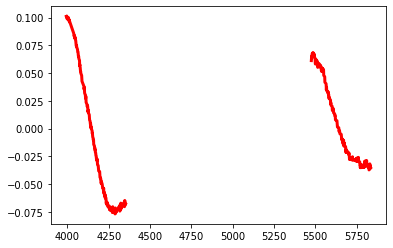

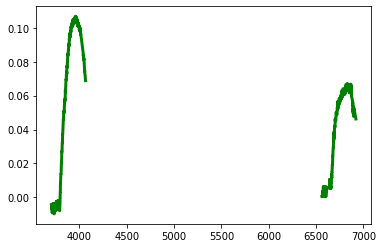

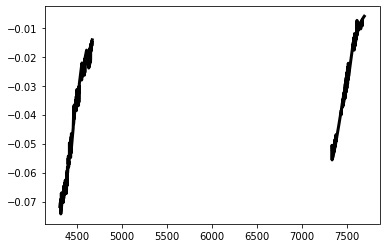

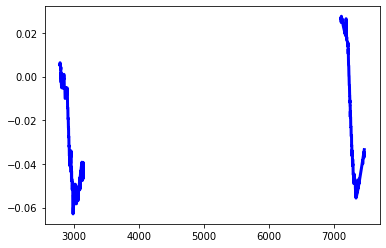

In [125]:
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = ts_log_mov_diff.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)
    plt.show()

# Anomaly Discovery

In [126]:
# per trovare le anomalie
from matrixprofile.discords import discords

Parameters  
- mp: matrix profile numpy array
- k: the number of discords to discover
- ex_zone: the number of samples to exclude and set to Inf on either side of a found discord    

Returns 
 - a list of indexes represent the discord starting locations. MaxInt indicates there were no more discords that could be found due to too many exclusions or profile being too small. Discord start indices are sorted by highest matrix profile value.

In [127]:
anoms = discords(mp, ex_zone=3, k=5) #trovo le top 5 anomalie di lunghezza 3

In [128]:
anoms #indici delle anomalie

array([   0,    3,    6, 3398, 3401])

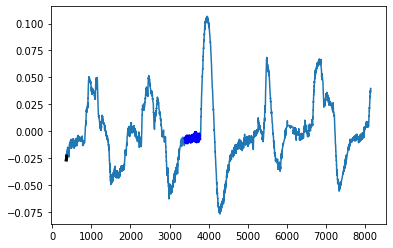

In [129]:
#plotto le anomalie, cioè i valori più distanti tra di loro nella matrix profile
plt.plot(ts_log_mov_diff.values)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
for a, c in zip(anoms, colors):
    a_shape = ts_log_mov_diff.values[a:a+w]
    plt.plot(range(a, a+w), a_shape, color=c, lw=3)

plt.show()